# Using yt for Visualization at OLCF

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (7.0, 5.0)

In [2]:
# suppress NumPy warning for log10 in VR
import numpy as np
np.seterr(invalid="ignore")

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

### About yt

* yt is a python library for analysis and visualization of volumetric datasets (e.g., from hydrodynamics codes)
  - active, welcoming community of developers
  - http://yt-project.org/

* supports adaptive mesh refinement, unstructured grids, and more

* _frontends_ provided for many common codes (e.g., _BoxLib_, _Chombo_, _Enzo_, _Flash_, _Gadget_, ...)
  - any 3-d NumPy array can also be used
  - generic HDF5 support as well

### About yt

- unlike VisIt or other codes, there is no GUI

- you write your visualization as a python script
  * you can also use ipython / jupyter notebooks
  
- **excellent cookbook** with all sorts of examples to base your vis off of: http://yt-project.org/docs/dev/cookbook/index.html

# Some Examples

In [3]:
import yt
yt.__version__

'3.4-dev'

In [4]:
yt.funcs.mylog.setLevel(50)

In [5]:
ds = yt.load("smallplt16623")
ds.print_stats()

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	   512	      16777216	           256
  1	   615	       6795264	           190
----------------------------------------------
   	  1127	      23572480


t = 1.63001201e+02 = 1.63001201e+02 s = 5.16519638e-06 years

Smallest Cell:
	Width: 6.482e-18 Mpc
	Width: 6.482e-12 pc
	Width: 1.337e-06 AU
	Width: 2.000e+07 cm


### Fields

* fields in yt have units
  - these are usually defined in the frontend for the different codes
  - units are propagated through calculations using SymPy

* many common derived fields are also computed, depending on what exists on disk

In [6]:
ds.field_list

[('boxlib', 'Temp'), ('boxlib', 'density')]

In [7]:
ds.derived_field_list

[('boxlib', 'Temp'),
 ('boxlib', 'cell_volume'),
 ('boxlib', 'density'),
 ('boxlib', 'dx'),
 ('boxlib', 'dy'),
 ('boxlib', 'dz'),
 ('boxlib', 'path_element_x'),
 ('boxlib', 'path_element_y'),
 ('boxlib', 'path_element_z'),
 ('boxlib', 'vertex_x'),
 ('boxlib', 'vertex_y'),
 ('boxlib', 'vertex_z'),
 ('boxlib', 'x'),
 ('boxlib', 'y'),
 ('boxlib', 'z'),
 ('gas', 'H_nuclei_density'),
 ('gas', 'He_nuclei_density'),
 ('gas', 'averaged_density'),
 ('gas', 'cell_mass'),
 ('gas', 'cell_volume'),
 ('gas', 'density'),
 ('gas', 'density_gradient_magnitude'),
 ('gas', 'density_gradient_x'),
 ('gas', 'density_gradient_y'),
 ('gas', 'density_gradient_z'),
 ('gas', 'dx'),
 ('gas', 'dy'),
 ('gas', 'dynamical_time'),
 ('gas', 'dz'),
 ('gas', 'emission_measure'),
 ('gas', 'entropy'),
 ('gas', 'kT'),
 ('gas', 'mazzotta_weighting'),
 ('gas', 'path_element_x'),
 ('gas', 'path_element_y'),
 ('gas', 'path_element_z'),
 ('gas', 'szy'),
 ('gas', 'temperature'),
 ('gas', 'vertex_x'),
 ('gas', 'vertex_y'),
 ('gas'

In [8]:
dd = ds.all_data()
dd.quantities.extrema(("boxlib", "density"))

YTArray([  3.20258364e-03,   1.85814420e+07]) g/cm**3

### Mesh

yt can explore the mesh structure for AMR datasets

In [9]:
print(ds.index.grid_left_edge)

[[ -5.12000000e+09  -5.12000000e+09  -5.12000000e+09]
 [  3.84000000e+09  -5.12000000e+09  -5.12000000e+09]
 [  2.56000000e+09  -5.12000000e+09  -5.12000000e+09]
 ..., 
 [ -3.20000000e+08   1.60000000e+09   0.00000000e+00]
 [  1.60000000e+09   6.40000000e+08   6.40000000e+08]
 [  1.60000000e+09   0.00000000e+00   6.40000000e+08]] code_length


### Metadata

* Many frontends store metadata (like input parameters, etc) in the plotfiles
* E.g., BoxLib plotfiles store the git hashes of the source used to build the executable

In [10]:
keys = [key for key in ds.parameters.keys() if "hash" in key]
for k in keys:
    print(k, ds.parameters[k])

('wdmerger git hash', '7aa52effdabf7e9dd944f7d93aaae59547b7ea98')
('Castro   git hash', '3b3824ed64fb7f94134718f3a0b5d7cb8c307573')
('BoxLib   git hash', '3bccd760d7c027b9ce7533d08fd8c549dc314c9a')


# Plotting

### Common Plot Types

* _projection plot_ : integrate through volume along a line (coordinate direction or off-axis).  Can optionally be weighted

* _slice plot_ : take a slice through the volume

* _volume rendering_ : assign an opacity and color to different data values and render an image by shooting lightrays through the volume

* _phase plot_ : plot two fields against one-another, optionally coloring by a different quantity


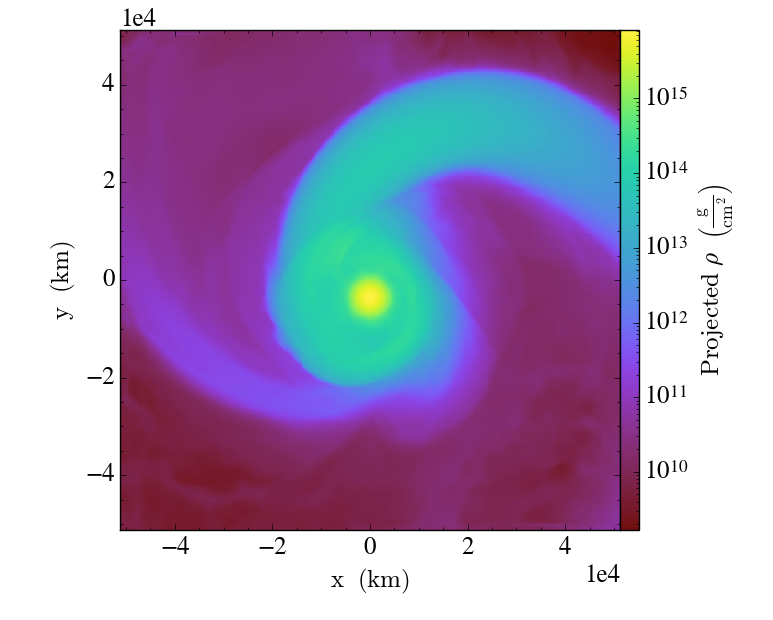

In [11]:
p = yt.ProjectionPlot(ds, "z", "density")
p.set_figure_size(5)
d = p.show()


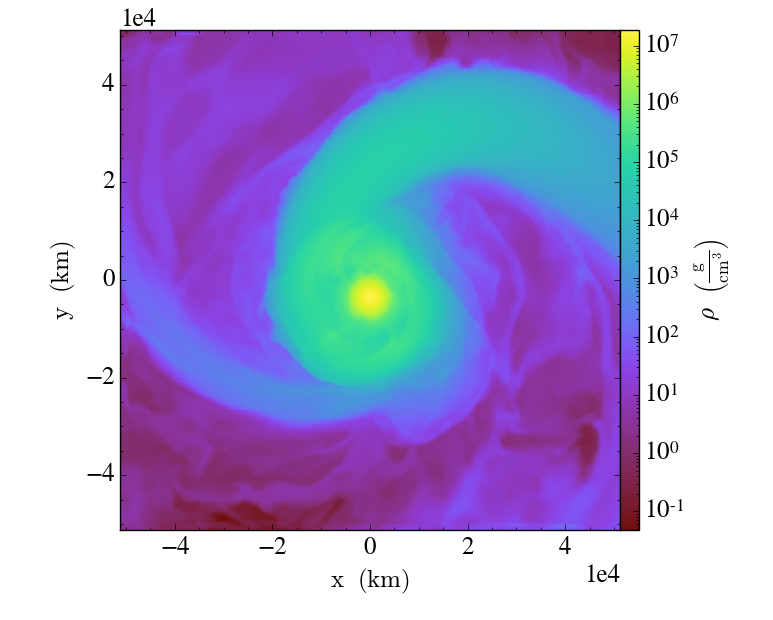

In [12]:
s = yt.SlicePlot(ds, "z", "density")
s.set_figure_size(5.0)
s.show()

### Volume rendering

Volume rendering requires a little bit of setup.  
The key pieces are:
* _transfer function_ : this maps the data values into colors and opacities

* _scene_ : this is the "box" containing the volume that will be rendered.  It contains the camera and volume sources

* _camera_ : this is the viewing point -- lightrays cast through the volume are imaged by the camera, optionally altered by a lens

* _sources_ : this includes the volume source (e.g. our data set), as well as annotation sources (like lines, etc.)

In [13]:
ds.periodicity = (True, True, True)

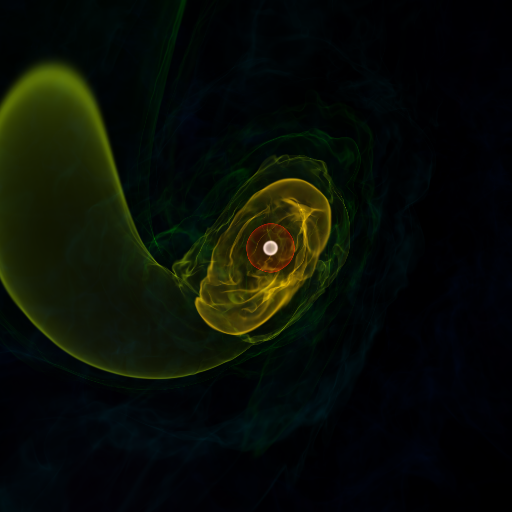

In [14]:
from yt.visualization.volume_rendering.api import Scene, VolumeSource

sc = Scene()

vol = VolumeSource(ds.all_data(), "density")
sc.add_source(vol)
cam = sc.add_camera(ds, lens_type="perspective")
im = sc.render()
sc.show()

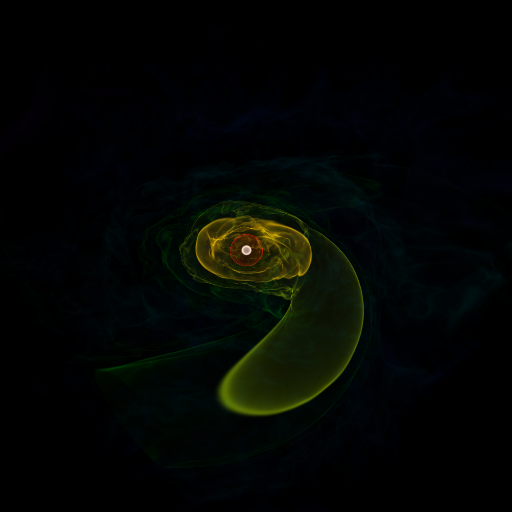

In [15]:
import numpy as np

cam.position = 1.5*ds.domain_right_edge
center = 0.5*(ds.domain_left_edge + ds.domain_right_edge)

normal = (center - cam.position)
normal /= np.sqrt(normal.dot(normal))

cam.switch_orientation(normal_vector=normal, north_vector=[0., 0., 1.])

im = sc.render()
sc.show()

# Using yt at OLCF

### Installing the Dev Version on Titan

* **You must be on a lustre filesystem so the compute nodes will see yt**

* Good place to install -- you project work directory
  - create a subdirectory, `yt/` in your project space for the install
  

In your project `yt/` directory, get the install script:
```
wget https://bitbucket.org/yt_analysis/yt/raw/yt/doc/install_script.sh
```
edit the script and set:
```
INST_CONDA=1
INST_YT_SOURCE=1
```
This will use Conda to install the dependencies and build yt from source
```
source install_script.sh
```
This will install all the dependencies in a sub-directory `yt-conda`.  When it is done, it will tell you to modify your `PATH` variable in your `.bashrc`, and then you are set.

**Note**: make sure that you are not loading any other python environments via modules, or else things will be confused.

### Testing the Installation

Launch `ipython` and at the prompt do
```
In [1]: import yt
```
if no errors are produced, then yt was found and your installation was successful

### Batch Visualization on Titan

Create a simple script, `vol.py`:
```
#!/usr/bin/env python

import yt

ds = yt.load("smallplt16623")

p = yt.ProjectionPlot(ds, "z", "density")
p.save()
```
and make it executable:
```
chmod o+x vol.py
```


### Batch Visualization on Titan

We'll run on a single node.

Sample submission script:
```
#!/bin/sh
#PBS -A XXXXXX
#PBS -N visualization
#PBS -j oe
#PBS -q debug
#PBS -l walltime=00:05:00,nodes=1

# this script runs with yt to volume render

export OMP_NUM_THREADS=16
cd $PBS_O_WORKDIR

aprun ./vol.py
```
Note that you still launch via `aprun` so it is executed on the compute node.  Submit this as usual.

![image](smallplt16623_Projection_z_density.png)

### Other Notes

* yt can use OpenMP (critical parts are written in Cython and are threaded)

* you can use something like `wraprun` to do trivial-parallel rendering of multiple output files on many nodes

* you can do the same install process on rhea
  - there we've also had luck compiling mpi4py and running yt using MPI across nodes